In [83]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [106]:
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_min
fmax = 1 / lambda_max
fcen = 0.5 * (fmin+fmax)
df = fmin - fmax
resolution = 100
nfreq = 50

In [85]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000005
Iteration   1, error: 0.000018
Iteration   2, error: 0.000011
Iteration   3, error: 0.000017
Iteration   4, error: 0.000057
Iteration   5, error: 0.000013
Iteration   6, error: 0.000006
Iteration   7, error: 0.000011
Iteration   8, error: 0.000018
Iteration   9, error: 0.003289
Iteration  10, error: 0.000011
Iteration  11, error: 0.000008
Iteration  12, error: 0.000018
Iteration  13, error: 0.000023
Iteration  14, error: 0.000014
Iteration  15, error: 0.000011
Iteration  16, error: 0.000018
Iteration  17, error: 0.000010
Iteration  18, error: 0.000013
Iteration  19, error: 0.000006
Iteration  20, error: 0.000014
Iteration  21, error: 0.000033
Iteration  22, error: 0.000007
Iteration  23, error: 0.000023
Iteration  24, error: 0.000009
Iteration  25, error: 0.000024
Iteration  26, error: 0.000019
Iteration  27, error: 0.000009
Iteration  28, error: 0.000029
Iteration  29, error: 0.000009
Optimal error: 0.000005
Iteration   0, error: 54.483567
Iteration   1,

In [ ]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [87]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [88]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [89]:
pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

In [90]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [91]:
cell_size = mp.Vector3(30, 2, 0)

In [107]:
source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.ContinuousSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=source_center
)]

In [108]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


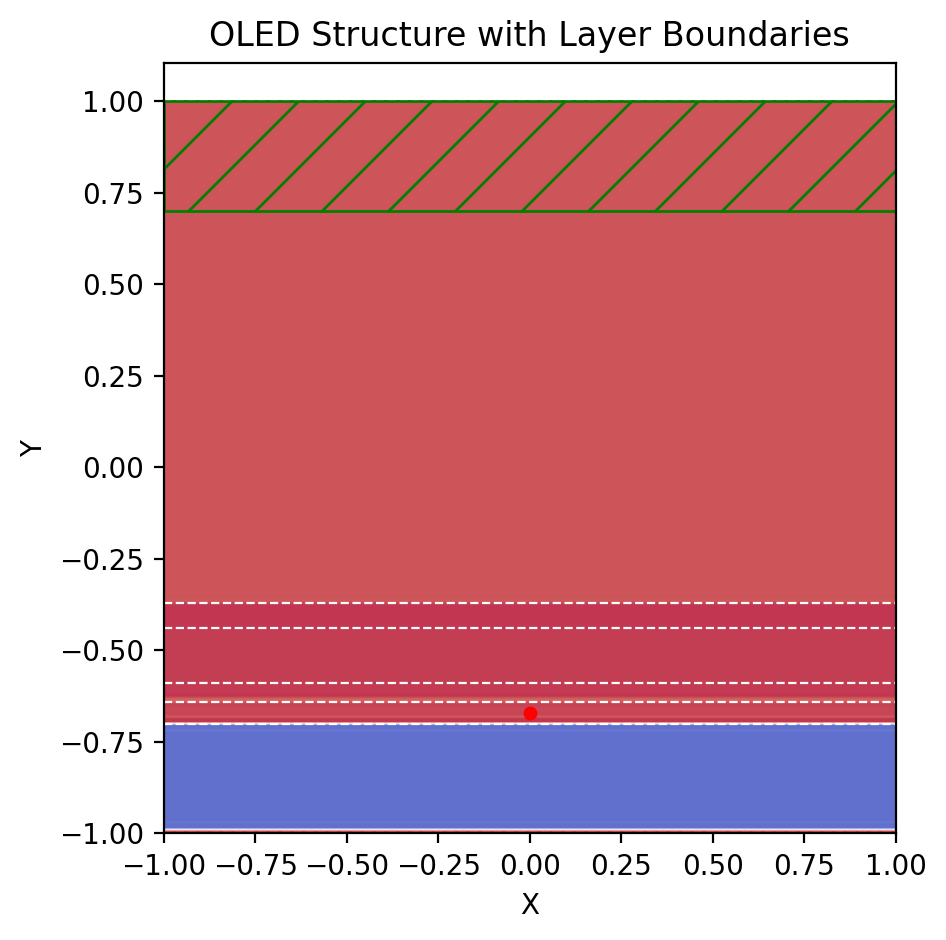

In [109]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

In [110]:
# --- Flux 모니터 4면 등록 (tight box 기준) ---
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

# 박스 4면
box_power = sim.add_flux(
    fcen, df, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    )
)

In [111]:
# --- 시뮬레이션 실행 ---
# sim.run(until_after_sources=mp.stop_when_fields_decayed(
#     50, mp.Ey, source_center, 1e-3))

sim.run(until=50)
net_power = mp.get_fluxes(box_power)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000355005 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [101]:
for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

sim.plot2D(
    output_plane=mp.Volume(center = mp.Vector3(0,-0.67,0), size = mp.Vector3(0.2,0.2,0)),
    # eps_parameters={'cmap': 'magma', 'alpha': 1.0},
    ax = ax
)
center_x = 0
center_y = -0.67
size_x = 0.2
size_y = 0.2
# === 실제 확대 영역 설정 ===
ax.set_xlim(center_x - size_x/2, center_x + size_x/2)
ax.set_ylim(center_y - size_y/2, center_y + size_y/2)

plt.show()

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


In [102]:
frequencies = mp.get_flux_freqs(box_power)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
0.7000		-4.678025e-04
0.6947		-2.247438e-03
0.6896		-2.071333e-04
0.6844		-2.460228e-03
0.6794		9.766094e-05
0.6745		-2.692659e-03
0.6696		4.394445e-04
0.6647		-2.928927e-03
0.6600		8.058342e-04
0.6553		-3.145960e-03
0.6507		1.179229e-03
0.6462		-3.312569e-03
0.6417		1.536631e-03
0.6372		-3.387759e-03
0.6329		1.848832e-03
0.6286		-3.317581e-03
0.6243		2.078621e-03
0.6201		-3.029964e-03
0.6160		2.177962e-03
0.6119		-2.427043e-03
0.6079		2.084408e-03
0.6039		-1.374590e-03
0.6000		1.717510e-03
0.5961		3.120042e-04
0.5923		9.764304e-04
0.5885		2.886392e-03
0.5848		-2.594791e-04
0.5811		6.697312e-03
0.5775		-2.124696e-03
0.5739		1.222819e-02
0.5704		-4.752272e-03
0.5669		2.016371e-02
0.5634		-8.241987e-03
0.5600		3.151254e-02
0.5566		-1.259518e-02
0.5533		4.785338e-02
0.5500		-1.757228e-02
0.5467		7.186991e-02
0.5435		-2.234396e-02
0.5404		1.086350e-01
0.5372		-2.450560e-02
0.5341		1.691308e-01
0.5310		-1.675262e-02
0.5280		2.819548e-01
0.5250		2.748376e-02
0.522

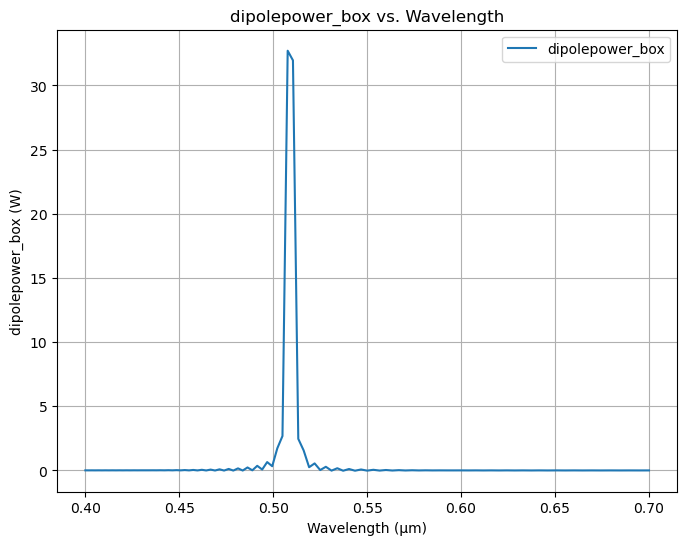

In [103]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power, '-', label='dipolepower_box')
plt.xlabel('Wavelength (μm)')
plt.ylabel('dipolepower_box (W)')
plt.title('dipolepower_box vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14

plt.legend()
plt.grid(True)
plt.show()

In [100]:
dp_power = net_power

dp_box = net_power;                     
dp = dipolepower(f)/sourcepower(f);
sp = sourcepower(f);

NameError: name 'dipolepower' is not defined

In [ ]:
# dp_box = np.array(net_power)                 # 구조 내 박스 모니터 총 power

# === homogeneous 구조에서 dipole power 측정 ===
# → 별도 시뮬레이션에서 저장해둔 source power 배열 불러오기
# 예: source_power = np.load("homogeneous_source_power.npy")
# 지금은 예시로 직접 넣어둘게
source_power = net_power
dp = net_power / source_power                   # 구조 내 box power 정규화
sp = source_power                            # 실제 source power

# === 결과 시각화 ===
plt.figure(figsize=(8,5))
plt.plot(wavelengths, dp, label="dipole_power_box (normalized)", linestyle='--')
plt.plot(wavelengths, sp, label="source_power", linestyle=':')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W or normalized)")
plt.title("Dipole Power Comparison (Meep Equivalent to Lumerical)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 결과 저장 (Lumerical 형식 비슷하게) ===
# .npz 파일로 저장
np.savez("dipole_power_data_meep.npz",
         wavelength=wavelengths,
         frequency=frequencies,
         dipole_power_box=dp_box,
         dipole_power=dp,
         source_power=sp)

In [ ]:
net_power = Px1 + Px2 + Py1 + Py2 + Pz1 + Pz2;


dp_box = net_power;                     
dp = dipolepower(f)/sourcepower(f);
sp = sourcepower(f);


T = matrixdataset("T");
T.addparameter("lambda",c/f,"f",f);
T.addattribute("T",net_power);

dipole_power = matrixdataset("dipole_power");
dipole_power.addparameter("lambda",c/f,"f",f);
dipole_power.addattribute("dipole_power",dp);         # actual power radiated as measured by dipolepower function, normalized to source power (power radiated by dipole in homogeneous material)
dipole_power.addattribute("dipole_power_box",dp_box); # actual power radiated as measured by box, normalized to source power (power radiated by dipole in homogeneous material)
dipole_power.addattribute("source_power",sp);         # power radiated radiated by dipole in homogeneous material, in Watts
